# Data Preparation
**Author:** Troy Holdsworth |
**Subject:** Western Power Hack-a-Gig - Challenge 1 |
**Date of Submission:** 25/10/2018

### Purpose
Tidy-up and data munging of the datasets which are single .csv files.

### [Task List](https://github.com/cobleg/Hack-A-Gig/wiki/Hack-A-Gig-Challenge-1:-Smart-Meters)
1. Download data - COMPLETE
2. Prepare data for exploratory analysis
    1. Link data files to facilitate exploration of relationships between variables.
    2. Identify and flag missing values, outliers.
    3. Create time index, binary variables for the time of day, week and year.
    4. Create a tidy data set (for information see: https://vita.had.co.nz/papers/tidy-data.pdf)

# Setup
## Import Dependencies

In [1]:
import numpy as np
from scipy.stats import variation
import pandas as pd
import bcolz
import dask.dataframe as dd
import pyarrow
import matplotlib.pyplot as plt

import os
%matplotlib inline

## Helper Functions

In [2]:
def pass_through(x):
    '''Returns the object which was passed in.'''
    return x

def columns_to_lowercase(df):
    '''Returns df with all column names in lowercase.'''
    df.columns = df.columns.str.lower().str.strip()
    return df

def columns_remove_spaces(df,replace_with=None):
    '''Returns df with spaces removed from beginning and end of column names.'''
    if replace_with == None:
        df.columns = df.columns.str.strip()
    else:
        df.columns = df.columns.str.replace(' ',replace_with)
    return df

def columns_rename(df,column_names):
    '''Returns df with the columns renames (used in Pipe)'''
    df.columns = column_names
    return df

def index_rename(df,index_names = ['index']):
    '''Returns df with the index renamed (used in Pipe)'''
    df.index.names = index_names
    return df

def coefficient_of_variation(series,kwargs=None):
    '''Returns the coefficient of variation of a series.'''
    if kwargs == None:
        return series.std() / series.mean()
    else:
        return series.std(**kwargs) / series.mean(**kwargs)
    
def summarize_dataframe(df):
    '''Return a summary table of staticical measures.'''
    return df.select_dtypes('float64').apply([min,np.mean,max,np.median,coefficient_of_variation]).T

In [3]:
#Monkey patch the DataFrame object with a function that returns the first and last x rows of dataframe.
pd.DataFrame.ends = lambda df, x = 3: df.head(x).append(df.tail(x)) #Return the first and last x rows of a dataframe.

#Monkey patch the series object with a function that returns the coefficient of variation
pd.Series.variation = lambda series: series.std() / series.mean() 

#Monkey path the DataFrame object with a function that returns a table of summary statistics
pd.DataFrame.stats = lambda df: df.select_dtypes('float64').apply([min,
                                                                   np.mean,
                                                                   np.median,
                                                                   np.max,
                                                                   np.std,
                                                                   coefficient_of_variation]).T

# Import Data

In [4]:
#Set up folder locations
dir_root = os.getcwd()
dir_input = os.path.join(dir_root,'data')
dir_working = os.path.join(dir_root,'temp')
dir_output = os.path.join(dir_root,'output')

assert os.path.exists(dir_root)
assert os.path.exists(dir_input)
assert os.path.exists(dir_working)
assert os.path.exists(dir_output)

In [5]:
print('Single File Datasets:')
for item in os.listdir(dir_input):
    if (item[-4:] == '.csv'):
        print(" - ",item)
print(chr(10))
print('Multi File Datasets:')
for item in os.listdir(dir_input):
    if (item[-4:] != '.csv'):
        print(" - ",item)

Single File Datasets:
 -  acorn_details.csv
 -  weather_daily_darksky.csv
 -  uk_bank_holidays.csv
 -  weather_hourly_darksky.csv
 -  informations_households.csv


Multi File Datasets:
 -  hhblock_dataset
 -  daily_dataset
 -  halfhourly_dataset


## Single File Datasets
### Bank Holidays

In [6]:
#Import the uk_bank_holidays dataset and tidy it up
df_bank_holidays = (pd.read_csv(os.path.join(dir_input,'uk_bank_holidays.csv'))
                    .pipe(columns_to_lowercase,)
                    .pipe(columns_remove_spaces,replace_with='_')
                    .set_index('bank_holidays')
                   )

In [7]:
def is_bank_holiday(date_series, bank_holidays=df_bank_holidays.index):
    '''Returns Series of booleans indicating whether each item in date_series is a bank holiday.'''
    if date_series.dtype == np.dtype('datetime64[ns]'):
        return date_series.date.isin(bank_holidays)
    else:
        return pd.to_datetime(date_series).isin(bank_holidays)

In [8]:
#Export to the working folder as a feather file
## NOTE: We have to reset the index as feather supports only integer indexes.
df_bank_holidays.pipe(index_rename).reset_index().to_feather(os.path.join(dir_working,'uk_bank_holidays'))

In [9]:
df_bank_holidays.ends()

,type
index,
2012-12-26,Boxing Day
2012-12-25,Christmas Day
2012-08-27,Summer bank holiday
2014-04-21,Easter Monday
2014-04-18,Good Friday
2014-01-01,New Year?s Day


### Daily Weather Data

In [10]:
## Weather Data - Daily
df_weather_daily = (pd.read_csv(os.path.join(dir_input,'weather_daily_darksky.csv'),parse_dates=['time'])
                    .pipe(columns_to_lowercase,)
                    .pipe(columns_remove_spaces,replace_with='_')
                    .astype({'preciptype':'category','icon':'category'})
                    .set_index('time')
                    .sort_index()
                   ) #The summary column here contains too many values to be practical as a category

In [11]:
#Identify all the columns which are likely to be dates/times
time_columns = dict([(column,'datetime64[ns]') 
                     for column in df_weather_daily.columns 
                     if 'time' in column])

time_column_list = list(time_columns.keys())

In [12]:
#Seems the uvindextime column has a null value.
(df_weather_daily[time_column_list].isnull()
 .stack()
 .reset_index()
 .pipe(columns_rename,['time','variable','has_nulls'])
 .pivot_table(index='variable',
              columns='has_nulls',
              values='time',
              aggfunc=len,
              fill_value=0)
)

has_nulls,False,True
variable,,
apparenttemperaturehightime,882,0
apparenttemperaturelowtime,882,0
apparenttemperaturemaxtime,882,0
apparenttemperaturemintime,882,0
sunrisetime,882,0
sunsettime,882,0
temperaturehightime,882,0
temperaturelowtime,882,0
temperaturemaxtime,882,0


In [13]:
#Convert time columns to datetimes
for column in time_column_list:
    df_weather_daily[column] = pd.to_datetime(df_weather_daily[column], errors='coerce')

In [14]:
#Add a column representing the date
df_weather_daily['date'] = pd.to_datetime(df_weather_daily.index.date)

In [15]:
#Create indexes of the sunrise and sunset times, so they can be easily mapped elsewhere
index_sunrise_time = df_weather_daily.set_index('date')['sunrisetime'].to_dict()
index_sunset_time = df_weather_daily.set_index('date')['sunsettime'].to_dict() 

In [16]:
#For some reason, the feather format doesn't like the date column (mixed type objects error), so it needs to be removed.
df_weather_daily = df_weather_daily.drop(labels='date',axis=1)

In [17]:
#Export the tidy data to the working folder as a feather file. 
## NOTE: We have to reset the index as feather supports only integer indexes.
## The index is renamed in order to simplify the import process later (this will be done for all exported dataframes)
df_weather_daily.pipe(index_rename).reset_index().to_feather(os.path.join(dir_working,'weather_daily_darksky'))

In [18]:
#Check out the data (transpose it for easier reading)
df_weather_daily.ends(3).T

index,2011-11-01 00:00:00,2011-11-02 00:00:00,2011-11-03 00:00:00,2014-03-29 00:00:00,2014-03-30 00:00:00,2014-03-30 23:00:00
temperaturemax,15.57,15.19,17.41,18.47,19.82,16.37
temperaturemaxtime,2011-11-01 15:00:00,2011-11-02 23:00:00,2011-11-03 14:00:00,2014-03-29 14:00:00,2014-03-30 12:00:00,2014-03-31 13:00:00
windbearing,208,134,154,105,114,138
icon,partly-cloudy-day,partly-cloudy-night,partly-cloudy-day,clear-day,partly-cloudy-day,partly-cloudy-day
dewpoint,10.13,10.23,13.39,5.37,5.81,7.61
temperaturemintime,2011-11-01 22:00:00,2011-11-02 03:00:00,2011-11-03 21:00:00,2014-03-29 01:00:00,2014-03-30 05:00:00,2014-03-31 06:00:00
cloudcover,0.36,0.39,0.52,0.08,0.31,0.32
windspeed,2.45,4.39,3.99,4.19,2.18,1.92
pressure,1009.46,1004.79,993.4,1014.25,1013.04,1012.74
apparenttemperaturemintime,2011-11-01 22:00:00,2011-11-02 03:00:00,2011-11-03 21:00:00,2014-03-29 02:00:00,2014-03-30 04:00:00,2014-03-31 06:00:00


In [19]:
#Summary Statistics for the hourly weather data
weather_daily_stats = df_weather_daily.stats()
weather_daily_stats.to_csv(os.path.join(dir_output,'weather_daily_darksky__stats.csv'));weather_daily_stats

,min,mean,median,amax,std,coefficient_of_variation
temperaturemax,-0.06,13.660113,12.625,32.40,6.182744,0.452613
dewpoint,-7.84,6.530034,6.380,17.77,4.830875,0.739793
cloudcover,0.00,0.477605,0.470,1.00,0.193514,0.405175
windspeed,0.20,3.581803,3.440,9.96,1.694007,0.472948
pressure,979.25,1014.127540,1014.615,1040.92,11.073038,0.010919
apparenttemperaturehigh,-6.46,12.723866,12.470,32.42,7.279168,0.572088
visibility,1.48,11.167143,11.970,15.34,2.466109,0.220836
humidity,0.43,0.781871,0.790,0.98,0.095348,0.121949
apparenttemperaturelow,-8.88,6.085045,5.315,20.54,6.031967,0.991277
apparenttemperaturemax,-4.11,12.929467,12.625,32.42,7.105426,0.549553


## Create a Time Index
The sunrise and sunset times are included in the daily weather data. It might be useful to extract these into a separate dataset, so that we can label the timeseries as being during the day or night.

In [20]:
df_time_index = (df_weather_daily[['sunrisetime','sunsettime']].copy(deep=True)
                     .pipe(columns_rename,['sunrise','sunset'])
                     .stack()
                     .reset_index()
                     .pipe(columns_rename,['date','day_or_night','timestamp'])
                     .astype({'timestamp':'datetime64'})
                     .set_index('timestamp')
                     .drop('date',axis=1)
                     .resample('30min').ffill().bfill()
                    )

In [21]:
#Label each timestamp with whether or not it is 
df_time_index['day_or_night'] = df_time_index['day_or_night'].map({'sunrise':'day','sunset':'night'}).astype('category')

#Create an index so that we can easily map these by datetime key later.
index_day_or_night = df_time_index['day_or_night'].T.to_dict()

In [22]:
#Add some components of the datetime
df_time_index['year'] = df_time_index.index.year
df_time_index['yearfrac'] = df_time_index.index.dayofyear / 365 #Near enough is good enough
df_time_index['month'] = df_time_index.index.month
df_time_index['dayofmonth'] = df_time_index.index.day
df_time_index['dayofyear'] = df_time_index.index.dayofyear
df_time_index['dayofweek'] = df_time_index.index.dayofweek
df_time_index['hourofday'] = df_time_index.index.hour
df_time_index['minuteofhour'] = df_time_index.index.minute
df_time_index['date'] = df_time_index.index.date

In [23]:
df_time_index['datetime'] = df_time_index.index #.map(index_sunrise_time)

In [24]:
#What time was sunset that day?
df_time_index['sunset_time'] = df_time_index['date'].map(index_sunset_time).astype('datetime64')
df_time_index['sunrise_time'] = df_time_index['date'].map(index_sunrise_time).astype('datetime64')

In [25]:
#Fraction of the day to/from sunrset
df_time_index['timetosunset'] = (df_time_index['sunset_time'] - df_time_index.index) / pd.to_timedelta(24,'h')
df_time_index['timesaftersunset'] = (df_time_index.index - df_time_index['sunset_time']) / pd.to_timedelta(24,'h')

In [26]:
#Fraction of the day to/from sunrise
df_time_index['timetosunrise'] = (df_time_index['sunrise_time'] - df_time_index.index) / pd.to_timedelta(24,'h')
df_time_index['timesaftersunrise'] = (df_time_index.index - df_time_index['sunrise_time']) / pd.to_timedelta(24,'h')

In [27]:
#df_time_index['date'] = df_time_index['date'].astype('datetime64')

In [28]:
df_time_index = df_time_index.drop('date',axis=1)

In [29]:
#Export the tidy data to the working folder as a feather file. 
## NOTE: We have to reset the index as feather supports only integer indexes.
## The index is renamed in order to simplify the import process later (this will be done for all exported dataframes)
df_time_index.pipe(index_rename).reset_index().to_feather(os.path.join(dir_working,'time_index'))

In [30]:
#Look at a sample to verify it has worked as expected. Transpose for easier viewing
df_time_index.sample(10).T

index,2013-11-17 15:00:00,2012-10-31 15:30:00,2012-09-30 21:00:00,2014-03-25 10:30:00,2013-03-04 08:00:00,2012-05-27 23:00:00,2013-04-13 06:00:00,2013-06-29 16:30:00,2013-07-03 06:00:00,2012-07-19 12:00:00
day_or_night,day,day,night,day,day,night,day,day,day,day
year,2013,2012,2012,2014,2013,2012,2013,2013,2013,2012
yearfrac,0.879452,0.835616,0.750685,0.230137,0.172603,0.405479,0.282192,0.493151,0.50411,0.550685
month,11,10,9,3,3,5,4,6,7,7
dayofmonth,17,31,30,25,4,27,13,29,3,19
dayofyear,321,305,274,84,63,148,103,180,184,201
dayofweek,6,2,6,1,0,6,5,5,2,3
hourofday,15,15,21,10,8,23,6,16,6,12
minuteofhour,0,30,0,30,0,0,0,30,0,0
datetime,2013-11-17 15:00:00,2012-10-31 15:30:00,2012-09-30 21:00:00,2014-03-25 10:30:00,2013-03-04 08:00:00,2012-05-27 23:00:00,2013-04-13 06:00:00,2013-06-29 16:30:00,2013-07-03 06:00:00,2012-07-19 12:00:00


## Hourly Weather Data

In [31]:
## Weather Data - Hourly
df_weather_hourly = (pd.read_csv(os.path.join(dir_input,'weather_hourly_darksky.csv'))
                     .pipe(columns_to_lowercase,)
                     .astype({'preciptype':'category',
                              'icon':'category',
                             'summary':'category'})
                     
                    )
## Convert the time columns to datetime objects.
time_columns = dict([(column,'datetime64[ns]') for column in df_weather_hourly.columns if 'time' in column])
df_weather_hourly = df_weather_hourly.astype(time_columns).set_index('time').sort_index()

In [32]:
#Add a Pseudo-Forecast: Assume that the weather in three days time will be the same as the weather today.
## This will allow us to use a forecasted temperature as training data, to avoid data leakage. 
## In practice, using a legitimate weather forecast would be better. 
df_weather_hourly['temperature_lag_3_days'] = (df_weather_hourly['temperature'].ewm(span=3*24).mean()
                                               .bfill()
                                               .shift(freq='3d')
                                               .bfill()
                                              )

In [33]:
df_weather_hourly['date'] = pd.to_datetime(df_weather_hourly.index.date)
df_weather_hourly['datetime'] = df_weather_hourly.index
df_weather_hourly['day_or_night'] = df_weather_hourly['datetime'].map(index_day_or_night)

In [34]:
df_weather_hourly['sunrise_time_today'] = df_weather_hourly['date'].map(index_sunrise_time).astype('datetime64')
df_weather_hourly['sunrise_time_yesterday'] = df_weather_hourly['date'].shift(24).map(index_sunrise_time).bfill().astype('datetime64')

In [35]:
df_weather_hourly['sunset_time_today'] = df_weather_hourly['date'].map(index_sunset_time).astype('datetime64')
df_weather_hourly['sunset_time_yesterday'] = df_weather_hourly['date'].shift(24).map(index_sunset_time).bfill().astype('datetime64')

In [36]:
#df_weather_hourly[df_weather_hourly['date'] != pd.to_datetime(df_weather_hourly['sunset_time_today'].dt.date)]#

In [37]:
df_weather_hourly['sunrise_diff'] = (df_weather_hourly['datetime'] - df_weather_hourly['sunrise_time_today']) / np.timedelta64(24, 'h')

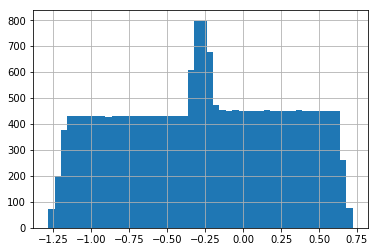

In [38]:
#Well, that doesn't look right?
df_weather_hourly['sunrise_diff'].hist(bins=48)

In [39]:
#There might be some missing dates in the weather data
df_weather_hourly[df_weather_hourly['sunrise_diff'] <-1][['datetime','sunrise_time_today']].head()

,datetime,sunrise_time_today
time,,
2012-03-25 00:00:00,2012-03-25 00:00:00,2012-03-26 05:49:47
2012-03-25 01:00:00,2012-03-25 01:00:00,2012-03-26 05:49:47
2012-03-25 02:00:00,2012-03-25 02:00:00,2012-03-26 05:49:47
2012-03-25 03:00:00,2012-03-25 03:00:00,2012-03-26 05:49:47
2012-03-25 04:00:00,2012-03-25 04:00:00,2012-03-26 05:49:47


In [40]:
#df_weather_hourly['hours_since_sunset'] = (df_weather_hourly['datetime'] - df_weather_hourly['sunset_time']) / np.timedelta64(24, 'h')

In [41]:
#df_weather_hourly['hours_since_sunrise'] = (df_weather_hourly['datetime'] - df_weather_hourly['sunrise_time']) / np.timedelta64(24, 'h')

In [42]:
#df_weather_hourly[['sunrise_time_today','sunrise_time_yesterday']]

In [43]:
#df_weather_hourly[['date','hours_since_sunrise','sunset_time']]

In [44]:
#Export the tidy data to the working folder as a feather file. 
## NOTE: We have to reset the index as feather supports only integer indexes.
## The index is renamed in order to simplify the import process later (this will be done for all exported dataframes)

df_weather_hourly.pipe(index_rename).reset_index().to_feather(os.path.join(dir_working,'weather_hourly_darksky'))

In [45]:
df_weather_hourly.ends(3)

,visibility,windbearing,temperature,dewpoint,pressure,apparenttemperature,windspeed,preciptype,icon,humidity,summary,temperature_lag_3_days,date,datetime,day_or_night,sunrise_time_today,sunrise_time_yesterday,sunset_time_today,sunset_time_yesterday,sunrise_diff
index,,,,,,,,,,,,,,,,,,,,
2011-11-01 00:00:00,13.63,160,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear,NaN,2011-11-01,2011-11-01 00:00:00,NaN,2011-11-01 06:54:29,2011-11-01 06:54:29,2011-11-01 16:36:03,2011-11-01 16:36:03,-0.287836
2011-11-01 01:00:00,13.26,154,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy,NaN,2011-11-01,2011-11-01 01:00:00,NaN,2011-11-01 06:54:29,2011-11-01 06:54:29,2011-11-01 16:36:03,2011-11-01 16:36:03,-0.246169
2011-11-01 02:00:00,12.94,161,13.65,12.14,1007.09,13.65,3.71,rain,clear-night,0.91,Clear,NaN,2011-11-01,2011-11-01 02:00:00,NaN,2011-11-01 06:54:29,2011-11-01 06:54:29,2011-11-01 16:36:03,2011-11-01 16:36:03,-0.204502
2014-03-31 20:00:00,14.07,141,13.62,7.91,1011.98,13.62,1.14,rain,partly-cloudy-night,0.68,Partly Cloudy,7.244360,2014-03-31,2014-03-31 20:00:00,NaN,NaT,2014-03-31 05:39:30,NaT,2014-03-31 18:32:05,NaN
2014-03-31 21:00:00,12.96,135,13.03,7.96,1011.97,13.03,1.11,rain,clear-night,0.71,Clear,7.288898,2014-03-31,2014-03-31 21:00:00,NaN,NaT,2014-03-31 05:39:30,NaT,2014-03-31 18:32:05,NaN
2014-03-31 22:00:00,13.13,110,12.51,7.97,1011.83,12.51,0.94,rain,clear-night,0.74,Clear,7.319887,2014-03-31,2014-03-31 22:00:00,NaN,NaT,2014-03-31 05:39:30,NaT,2014-03-31 18:32:05,NaN


In [46]:
#Summary Statistics for the hourly weather data
weather_hourly_stats = df_weather_hourly.stats()
weather_hourly_stats.to_csv(os.path.join(dir_output,'weather_hourly_darksky__stats.csv'));weather_hourly_stats

,min,mean,median,amax,std,coefficient_of_variation
visibility,0.180000,11.166485,12.260000,16.090000,3.099337,0.277557
temperature,-5.640000,10.471486,9.930000,32.400000,5.781904,0.552157
dewpoint,-9.980000,6.530501,6.570000,19.880000,5.041965,0.772064
pressure,975.740000,1014.125153,1014.780000,1043.320000,11.388337,0.011230
apparenttemperature,-8.880000,9.230338,9.360000,32.420000,6.940919,0.751968
windspeed,0.040000,3.905215,3.680000,14.800000,2.026854,0.519012
humidity,0.230000,0.781829,0.810000,1.000000,0.140369,0.179539
temperature_lag_3_days,-1.560976,10.471176,9.596229,24.023337,5.113829,0.488372
sunrise_diff,-1.283819,-0.263818,-0.259433,0.721389,0.532705,-2.019209


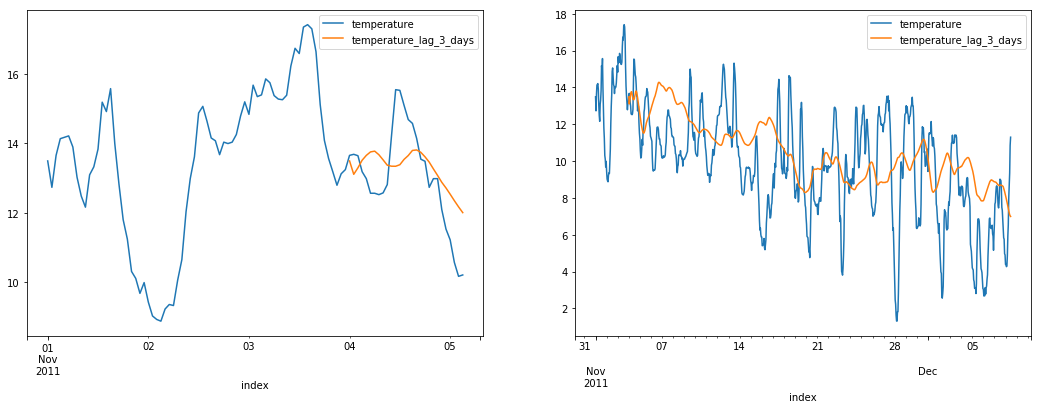

In [47]:
#How good is the forecast?
fig, axes = plt.subplots(1,2,figsize=(18,6))
df_weather_hourly.sort_index().iloc[:100][['temperature','temperature_lag_3_days']].plot(ax=axes[0])
df_weather_hourly.sort_index().iloc[:900][['temperature','temperature_lag_3_days']].plot(ax=axes[1])#.rolling('3d').mean().plot()

In [48]:
#What is the weather typically like?
df_weather_hourly['summary'].value_counts()

Partly Cloudy               6638
Mostly Cloudy               6095
Clear                       5771
Overcast                     979
Foggy                        693
Breezy and Mostly Cloudy     385
Breezy and Partly Cloudy     267
Breezy                       195
Breezy and Overcast           83
Windy and Mostly Cloudy       29
Windy                         18
Windy and Overcast             9
Windy and Partly Cloudy        3
Name: summary, dtype: int64

### Acorn Data

In [49]:
## Acorn data
df_acorn_details = (pd.read_csv(os.path.join(dir_input,'acorn_details.csv'),encoding='cp1252')
                    .pipe(columns_to_lowercase,)
                    .set_index(['main categories','categories','reference'])
                   )
df_acorn_details.sample(5)

acorn-a  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone               164.0   
DIGITAL         Social Media Brands (used at least weekly) Blogs/online forums    102.0   
                Internet Access: Usage in Last Week        8-19 hours             138.0   
                Sites regularly visited                    Wikipedia               98.0   
POPULATION      Religion                                   Muslim                  65.0   

                                                                                acorn-b  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone               111.0   
DIGITAL         Social Media Brands (used at least weekly) Blogs/online forums    112.0   
                Internet Access: Usage in Last Week        8-19 hours             123.0   
                Sites regularly visited                    Wikipedia              110.0   
POPULATION      Religion                                   Muslim                  44.0   

                                                                                acorn-c  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone                91.0   
DIGITAL         Social Media Brands (used at least weekly) Blogs/online forums    103.0   
                Internet Access: Usage in Last Week        8-19 hours             108.0   
                Sites regularly visited                    Wikipedia               88.0   
POPULATION      Religion                                   Muslim                  24.0   

                                                                                acorn-d  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone               308.0   
DIGITAL         Social Media Brands (used at least weekly) Blogs/online forums    162.0   
                Internet Access: Usage in Last Week        8-19 hours             123.0   
                Sites regularly visited                    Wikipedia              154.0   
POPULATION      Religion                                   Muslim                 132.0   

                                                                                acorn-e  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone               168.0   
DIGITAL         Social Media Brands (used at least weekly) Blogs/online forums    121.0   
                Internet Access: Usage in Last Week        8-19 hours             123.0   
                Sites regularly visited                    Wikipedia              135.0   
POPULATION      Religion                                   Muslim                 114.0   

                                                                                acorn-f  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone                86.0   
DIGITAL         Social Media Brands (used at least weekly) Blogs/online forums     93.0   
                Internet Access: Usage in Last Week        8-19 hours             106.0   
                Sites regularly visited                    Wikipedia               94.0   
POPULATION      Religion                                   Muslim                   6.0   

                                                                                acorn-g  \
main categories categories                                 reference                      
FINANCE         Financial Channel: Arrange Current Account By phone   

In [50]:
#Create a version of the acorn data with the acorn name as the index key (for merging)
df_acorn_index = df_acorn_details.T
df_acorn_index.sample(5)

main categories POPULATION                                                   \
categories             Age                                                    
reference          Age 0-4 Age 5-17 Age 18-24 Age 25-34 Age 35-49 Age 50-64   
acorn-o              123.0     89.0     117.0     140.0     102.0      89.0   
acorn-a               77.0    117.0      64.0      52.0     102.0     124.0   
acorn-i               63.0     67.0      62.0      63.0      76.0     112.0   
acorn-q              133.0    106.0     110.0     120.0     100.0      89.0   
acorn-d              100.0     69.0     107.0     197.0     124.0      72.0   

main categories                                                     \
categories                              Geography                    
reference       Aged 65-74 Aged 75 plus   England Northern Ireland   
acorn-o               73.0         72.0      97.0             95.0   
acorn-a              125.0        112.0     107.0             30.0   
acorn-i              182.0        220.0     102.0             30.0   
acorn-q               76.0         76.0      97.0             43.0   
acorn-d               55.0         49.0     114.0              2.0   

main categories      ...                  LEISURE TIME                         \
categories           ...      Holiday Destination/Type                          
reference            ...                Europe (other) USA / Canada Caribbean   
acorn-o              ...                          37.0         37.0      71.0   
acorn-a              ...                         402.0       2280.0     133.0   
acorn-i              ...                          97.0         62.0     112.0   
acorn-q              ...                          54.0         37.0      67.0   
acorn-d              ...                         214.0         84.0     153.0   

main categories                                         \
categories                                               
reference       Australia / New Zealand  Africa   Asia   
acorn-o                            58.0    54.0   96.0   
acorn-a                          3795.0  2652.0  171.0   
acorn-i                            58.0    59.0   72.0   
acorn-q                            58.0    54.0   63.0   
acorn-d                            58.0   424.0  220.0   

main categories                                                         
categories                                                              
reference       Activity / Outdoor Sports Cruise Package Self-catering  
acorn-o                              23.0   49.0    54.0          32.0  
acorn-a                             298.0  272.0   196.0         308.0  
acorn-i                              84.0   70.0   106.0         113.0  
acorn-q                              23.0   49.0    54.0          35.0  
acorn-d                             119.0   44.0    49.0          55.0  

[5 rows x 826 columns]

In [51]:
#List the Acorn types
acorn_types = set(df_acorn_index.index);acorn_types

{'acorn-a',
 'acorn-b',
 'acorn-c',
 'acorn-d',
 'acorn-e',
 'acorn-f',
 'acorn-g',
 'acorn-h',
 'acorn-i',
 'acorn-j',
 'acorn-k',
 'acorn-l',
 'acorn-m',
 'acorn-n',
 'acorn-o',
 'acorn-p',
 'acorn-q'}

In [52]:
#Export the tidy data to the working folder as a feather file. 
## NOTE: We have to reset the index as feather supports only integer indexes.
## The index is renamed in order to simplify the import process later (this will be done for all exported dataframes)

df_acorn_index.pipe(index_rename).to_csv(os.path.join(dir_working,'acorn_index.csv'))

In [53]:
#Summary Statistics for the acorn data
acorn_stats = df_acorn_index.stats()
acorn_stats.to_csv(os.path.join(dir_output,'acorn_details__stats.csv'));acorn_stats.round(2)

min  \
POPULATION   Age                              Age 0-4                                           63.0   
                                              Age 5-17                                          64.0   
                                              Age 18-24                                         62.0   
                                              Age 25-34                                         52.0   
                                              Age 35-49                                         67.0   
                                              Age 50-64                                         41.0   
                                              Aged 65-74                                        29.0   
                                              Aged 75 plus                                      32.0   
             Geography                        England                                           75.0   
                                              Northern Ireland                                   2.0   
                                              Scotland                                          31.0   
                                              Wales                                             10.0   
             Ethnicity                        White                                             80.0   
                                              Mixed                                             27.0   
                                              Asian                                              8.0   
                                              Black                                              6.0   
                                              Other ethnicity                                   18.0   
             Country of Birth                 UK / ROI                                          75.0   
                                              EU: Member countries in March 2001                46.0   
                                              EU: Accession countries April 2001 to March 2011  34.0   
                                              Rest of Europe                                    23.0   
                                              Africa                                            22.0   
                                              Middle East & Asia                                16.0   
                                              North America                                     41.0   
                                              Central America                                   35.0   
                                              South America                                     22.0   
                                              Caribbean                                         11.0   
                                              Antarctica & Oceania                              33.0   
             Religion                         Christian                                         74.0   
                                              Jewish                                            10.0   
...                                                                                              ...   
LEISURE TIME Interests & Hobbies              TV                                                45.0   
                                              Vegetarian Products                               55.0   
                                              Football Supporter                                70.0   
             Visit Pubs for a Drink - Day     Premium                                           36.0   
                                              Mass Market                                       35.0   
                                              Value                                             50.0   
             Visit Pubs for a Drink - Evening Premium                                           46.0   
                                         

### Household Data

In [54]:
##Household Data
df_households = (pd.read_csv(os.path.join(dir_input,'informations_households.csv'))
                 .pipe(columns_to_lowercase,)
                 .set_index('lclid')
                 .astype({'stdortou':'category',
                          'acorn':'category',
                          'acorn_grouped':'category'
                         })
                )

#Take a look at a sample
df_households.sample(5)

,stdortou,acorn,acorn_grouped,file
lclid,,,,
MAC003362,Std,ACORN-E,Affluent,block_29
MAC001145,Std,ACORN-A,Affluent,block_1
MAC003981,Std,ACORN-F,Comfortable,block_45
MAC000072,Std,ACORN-E,Affluent,block_31
MAC001405,ToU,ACORN-E,Affluent,block_40


In [55]:
df_households['file'].value_counts().value_counts() #There are 50 households per block, except for one block.

50    111
16      1
Name: file, dtype: int64

How many households in each acorn group?

In [56]:
df_households['acorn'].value_counts()

ACORN-E    1567
ACORN-Q     831
ACORN-F     684
ACORN-H     455
ACORN-L     342
ACORN-D     292
ACORN-G     205
ACORN-K     165
ACORN-A     157
ACORN-N     152
ACORN-C     151
ACORN-M     113
ACORN-J     112
ACORN-P     110
ACORN-O     103
ACORN-I      51
ACORN-U      49
ACORN-B      25
ACORN-        2
Name: acorn, dtype: int64

In [57]:
df_households.loc[df_households.groupby('file').groups['block_0']].head()

,stdortou,acorn,acorn_grouped,file
lclid,,,,
MAC005492,ToU,ACORN-,ACORN-,block_0
MAC001074,ToU,ACORN-,ACORN-,block_0
MAC000002,Std,ACORN-A,Affluent,block_0
MAC003613,Std,ACORN-A,Affluent,block_0
MAC003597,Std,ACORN-A,Affluent,block_0


In [58]:
df_households.reset_index().pivot_table(index='acorn',
                                        columns='acorn_grouped',
                                        values='lclid',
                                        aggfunc=len,
                                        fill_value=0,
                                        margins=True)

acorn_grouped,ACORN-,ACORN-U,Adversity,Affluent,Comfortable,All
acorn,,,,,,
ACORN-,2,0,0,0,0,2
ACORN-A,0,0,0,157,0,157
ACORN-B,0,0,0,25,0,25
ACORN-C,0,0,0,151,0,151
ACORN-D,0,0,0,292,0,292
ACORN-E,0,0,0,1567,0,1567
ACORN-F,0,0,0,0,684,684
ACORN-G,0,0,0,0,205,205
ACORN-H,0,0,0,0,455,455


In [59]:
#Are there any values of Acorn type in the households dataset which  are not in the acorn data
set(df_households['acorn'].str.lower()) - acorn_types

{'acorn-', 'acorn-u'}

It is evident that ACORN-U and ACORN reflects an "unknown" status, as they are not valid.